### **For one post_id**

In [12]:
import pandas as pd

def calculate_average_sentiment_post(target_post_id):
    df = pd.read_csv('data/comment_preprocessing.csv')
    filtered_df = df[df['post_id'] == target_post_id]
    if filtered_df.empty:
        return f"No sentiments found for postID: {target_post_id}"
    average_sentiment = round(filtered_df['RoBERTa_sentiment'].mean(), 2)
    return average_sentiment
  

In [14]:
# Example usage
csv_file_path = "data/comment_preprocessing.csv"  # Replace with your CSV file path
post_id_to_check = "1501ibb"       # Replace with the desired postID
result = calculate_average_sentiment_post(post_id_to_check)
print(f"Average sentiment for postID {post_id_to_check}: {result}")

Average sentiment for postID 1501ibb: -0.15


### **Upvote vs Average Sentiment**

In [17]:
import pandas as pd
import random
import matplotlib.pyplot as plt

# Load the data
sentiment_data = pd.read_csv('data/comment_preprocessing.csv')
upvote_data = pd.read_parquet('data/posts.parquet.brotli', engine='pyarrow')

# Select random postIDs
available_posts = upvote_data['post_id'].unique()
selected_posts = random.sample(list(available_posts), min(50, len(available_posts)))

In [32]:
upvote_data.head()

,post_id,subreddit,title,flair,score,creation_time,number_of_comments,upvote_ratio,upvote_bin
0,1501ibb,AskReddit,"What Worst possible reply to ""I'm pregnant""?",<NA>,11202,2023-07-15 04:06:56,12625,0.85,4
1,14zz798,AskReddit,What is a personal story you have that you don...,<NA>,6607,2023-07-15 02:12:11,2891,0.97,4
2,14zx7iq,AskReddit,How did that person in your class become rich?,<NA>,4251,2023-07-15 00:38:28,2542,0.94,4
3,150aarj,AskReddit,What is the worst reply to “I’m leaving you”?,<NA>,3608,2023-07-15 12:03:43,3564,0.89,4
4,150j9g1,AskReddit,Who's the Most Dangerous Human Alive Right Now?,<NA>,2287,2023-07-15 18:28:51,3389,0.66,2


In [19]:
# Calculate average sentiment for the selected posts
avg_sentiment_list = []
for post_id in selected_posts:
    avg_sentiment = calculate_average_sentiment_post(post_id)
    avg_sentiment_list.append({'post_id': post_id, 'avg_sentiment': avg_sentiment})

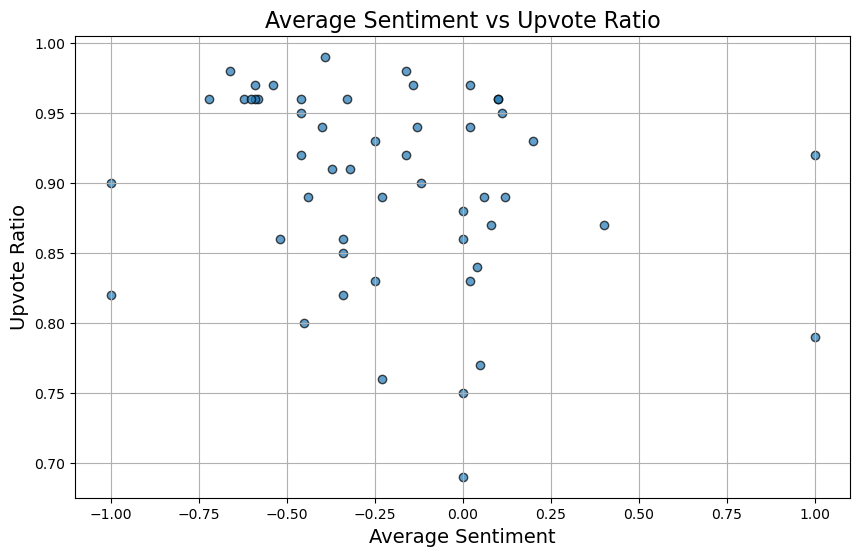

In [21]:
# Convert results to a DataFrame
avg_sentiment_df = pd.DataFrame(avg_sentiment_list)

avg_sentiment_df['avg_sentiment'] = pd.to_numeric(avg_sentiment_df['avg_sentiment'], errors='coerce')  # Convert non-numeric to NaN
avg_sentiment_df = avg_sentiment_df.dropna(subset=['avg_sentiment'])  # Drop rows with NaN in 'avg_sentiment'
avg_sentiment_df.head()
# Merge with upvote data
upvote_filtered = upvote_data[upvote_data['post_id'].isin(selected_posts)]
merged_data = pd.merge(avg_sentiment_df, upvote_filtered, on='post_id')

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['avg_sentiment'], merged_data['upvote_ratio'], alpha=0.7, edgecolor='k')
plt.title('Average Sentiment vs Upvote Ratio', fontsize=16)
plt.xlabel('Average Sentiment', fontsize=14)
plt.ylabel('Upvote Ratio', fontsize=14)
plt.grid(True)
plt.show()   

In [34]:
merged_data.head()

,post_id,avg_sentiment,subreddit,title,flair,score,creation_time,number_of_comments,upvote_ratio,upvote_bin
0,150j9g1,-0.34,AskReddit,Who's the Most Dangerous Human Alive Right Now?,<NA>,2287,2023-07-15 18:28:51,3389,0.66,2
1,150gu64,0.14,books,Are physical bookstores dying ?,<NA>,72,2023-07-15 16:49:52,141,0.77,3
2,151b6qq,-0.14,explainlikeimfive,eli5: Where did we start counting our years from?,Mathematics,38,2023-07-16 16:54:13,45,0.68,2
3,1525zyh,-0.47,technology,Amazon Told Drivers Not to Worry About In-Van ...,Privacy,4509,2023-07-17 16:01:58,310,0.97,4
4,152ajlf,-0.45,technology,Reddit nukes everyone’s pre-2023 chats and mes...,Social Media,606,2023-07-17 18:55:17,155,0.91,4


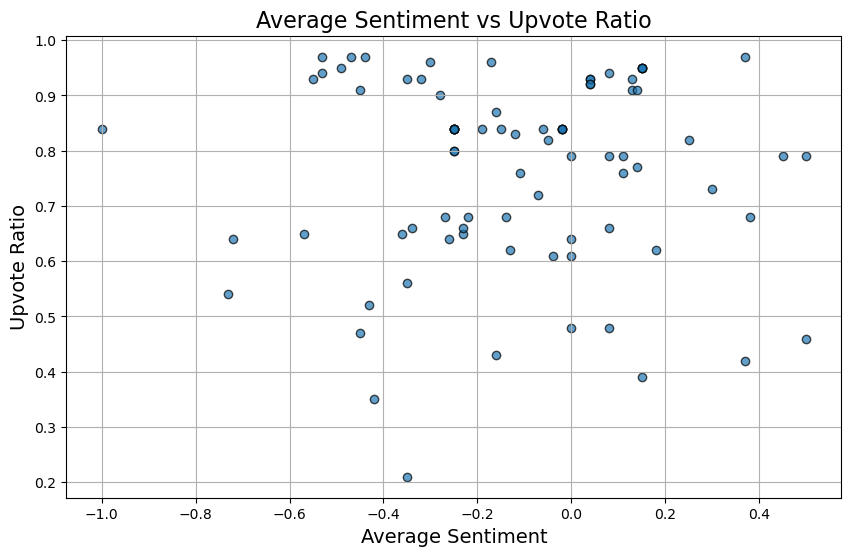

In [23]:
import pandas as pd
import random
import matplotlib.pyplot as plt

# Load the data
sentiment_data = pd.read_csv('data/comment_preprocessing.csv')
upvote_data = pd.read_parquet('data/posts.parquet.brotli', engine='pyarrow')

# Bin posts by upvote ratio
bins = 5  # Adjust number of bins for granularity
bin_labels = range(bins)  # Label each bin
upvote_data['upvote_bin'] = pd.cut(upvote_data['upvote_ratio'], bins=bins, labels=bin_labels)

# Select an equal number of posts from each bin
samples_per_bin = 20  # Adjust the number of samples per bin
selected_posts = []
for bin_label in bin_labels:
    bin_data = upvote_data[upvote_data['upvote_bin'] == bin_label]
    if not bin_data.empty:
        sampled_posts = bin_data['post_id'].sample(n=min(samples_per_bin, len(bin_data)), random_state=42)
        selected_posts.extend(sampled_posts.tolist())

# Filter upvote data for selected posts
filtered_upvote_data = upvote_data[upvote_data['post_id'].isin(selected_posts)]

# Calculate average sentiment for the selected posts
avg_sentiment_list = []
for post_id in filtered_upvote_data['post_id']:
    avg_sentiment = calculate_average_sentiment_post(post_id)  # Assuming this function is defined
    avg_sentiment_list.append({'post_id': post_id, 'avg_sentiment': avg_sentiment})

# Convert results to a DataFrame
avg_sentiment_df = pd.DataFrame(avg_sentiment_list)

# Convert avg_sentiment to numeric, dropping invalid entries
avg_sentiment_df['avg_sentiment'] = pd.to_numeric(avg_sentiment_df['avg_sentiment'], errors='coerce')
avg_sentiment_df = avg_sentiment_df.dropna(subset=['avg_sentiment'])  # Drop rows where avg_sentiment is NaN

# Merge average sentiment data with upvote data
merged_data = pd.merge(avg_sentiment_df, filtered_upvote_data, on='post_id')

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['avg_sentiment'], merged_data['upvote_ratio'], alpha=0.7, edgecolor='k')
plt.title('Average Sentiment vs Upvote Ratio', fontsize=16)
plt.xlabel('Average Sentiment', fontsize=14)
plt.ylabel('Upvote Ratio', fontsize=14)
plt.grid(True)
plt.show()


In [42]:
merged_data.head

print(merged_data.dtypes)


post_id                       object
avg_sentiment                float64
subreddit                   category
title                 string[python]
flair                 string[python]
score                          int64
creation_time         datetime64[ns]
number_of_comments             int64
upvote_ratio                 float64
upvote_bin                  category
dtype: object


### **Correlation Matrix**

In [50]:
import pandas as pd

# Select numerical columns
# Explicitly select the numerical columns you want
numerical_data = merged_data[['avg_sentiment', 'score', 'number_of_comments', 'upvote_ratio']]

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Print the correlation matrix
print(correlation_matrix)

# Save to a CSV file if needed
correlation_matrix.to_csv('correlation_matrix.csv')

                    avg_sentiment     score  number_of_comments  upvote_ratio
avg_sentiment            1.000000 -0.300749           -0.263408      0.009291
score                   -0.300749  1.000000            0.930795      0.087835
number_of_comments      -0.263408  0.930795            1.000000     -0.009619
upvote_ratio             0.009291  0.087835           -0.009619      1.000000


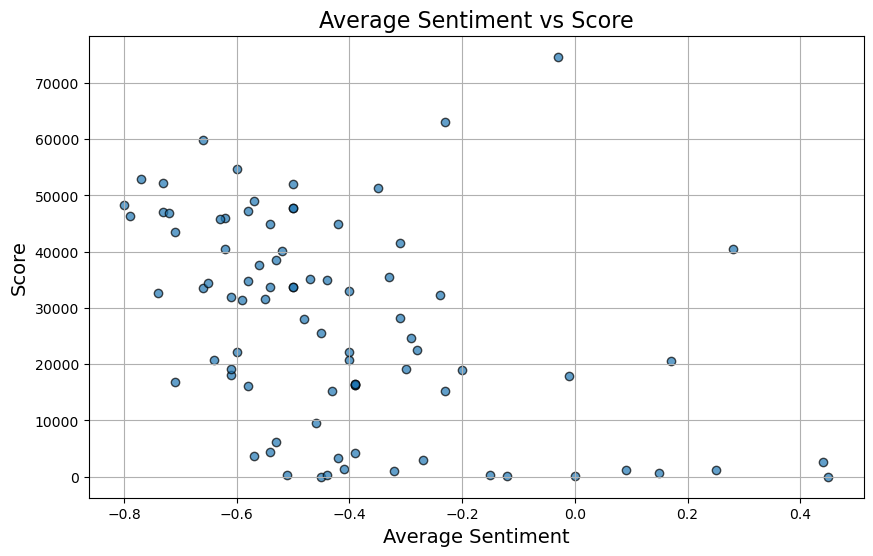

In [54]:
import pandas as pd
import random
import matplotlib.pyplot as plt

# Load the data
sentiment_data = pd.read_csv('data/comment_preprocessing.csv')
upvote_data = pd.read_parquet('data/posts.parquet.brotli', engine='pyarrow')

# Bin posts by upvote ratio
bins = 5  # Adjust number of bins for granularity
bin_labels = range(bins)  # Label each bin
upvote_data['upvote_bin'] = pd.cut(upvote_data['score'], bins=bins, labels=bin_labels)

# Select an equal number of posts from each bin
samples_per_bin = 20  # Adjust the number of samples per bin
selected_posts = []
for bin_label in bin_labels:
    bin_data = upvote_data[upvote_data['upvote_bin'] == bin_label]
    if not bin_data.empty:
        sampled_posts = bin_data['post_id'].sample(n=min(samples_per_bin, len(bin_data)), random_state=42)
        selected_posts.extend(sampled_posts.tolist())

# Filter upvote data for selected posts
filtered_upvote_data = upvote_data[upvote_data['post_id'].isin(selected_posts)]

# Calculate average sentiment for the selected posts
avg_sentiment_list = []
for post_id in filtered_upvote_data['post_id']:
    avg_sentiment = calculate_average_sentiment_post(post_id)  # Assuming this function is defined
    avg_sentiment_list.append({'post_id': post_id, 'avg_sentiment': avg_sentiment})

# Convert results to a DataFrame
avg_sentiment_df = pd.DataFrame(avg_sentiment_list)

# Convert avg_sentiment to numeric, dropping invalid entries
avg_sentiment_df['avg_sentiment'] = pd.to_numeric(avg_sentiment_df['avg_sentiment'], errors='coerce')
avg_sentiment_df = avg_sentiment_df.dropna(subset=['avg_sentiment'])  # Drop rows where avg_sentiment is NaN

# Merge average sentiment data with upvote data
merged_data = pd.merge(avg_sentiment_df, filtered_upvote_data, on='post_id')

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['avg_sentiment'], merged_data['score'], alpha=0.7, edgecolor='k')
plt.title('Average Sentiment vs Score', fontsize=16)
plt.xlabel('Average Sentiment', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(True)
plt.show()
